In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import shap


In [2]:
df = pd.read_csv("macro-economic-db-quarterly.csv", delimiter=";", index_col=0)
df = df.transpose()

df.reset_index(inplace=True)
df.rename(columns={"index":"stvrtrok"}, inplace=True)
for column in df.columns[1:]:
    df[column] = df[column].str.replace(",", "").astype(float)

columns_to_modify = df.columns.difference(["urok"])
df[columns_to_modify] = df[columns_to_modify].replace(0, np.nan)

df["bilancia"] = df.vyvoz - df.dovoz

df["NaN_Percentage"] = df.isna().sum(axis=1) / df.shape[1] * 100
df_cut =  df[df["NaN_Percentage"] <= 30].drop(columns=["NaN_Percentage"])
df_cut.reset_index(drop=True, inplace=True)

df_clean = df_cut.bfill()
df_clean = df_clean.ffill()

In [3]:
# Inicializácia štandardizérov
scaler_X = StandardScaler()
scaler_y_hdp = StandardScaler()
scaler_y_nezamestnanost = StandardScaler()
scaler_y_cpi = StandardScaler()

# HDP
X_hdp = df_clean[df_clean.columns.difference(["hdp", "stvrtrok"])]
y_hdp = df_clean.hdp.values.reshape(-1, 1)  # Reshape pre škálovanie

X_train_hdp, X_test_hdp, y_train_hdp, y_test_hdp = train_test_split(X_hdp, y_hdp, test_size=0.2, random_state=42)

# Štandardizácia
X_train_hdp = scaler_X.fit_transform(X_train_hdp)
X_test_hdp = scaler_X.transform(X_test_hdp)
y_train_hdp = scaler_y_hdp.fit_transform(y_train_hdp)
y_test_hdp = scaler_y_hdp.transform(y_test_hdp)

# Nezamestnanosť
X_nezamestnanost = df_clean[df_clean.columns.difference(["nezamestnanost", "stvrtrok"])]
y_nezamestnanost = df_clean.nezamestnanost.values.reshape(-1, 1)  # Reshape pre škálovanie

X_train_nezamestnanost, X_test_nezamestnanost, y_train_nezamestnanost, y_test_nezamestnanost = train_test_split(
    X_nezamestnanost, y_nezamestnanost, test_size=0.2, random_state=42
)

# Štandardizácia
X_train_nezamestnanost = scaler_X.fit_transform(X_train_nezamestnanost)
X_test_nezamestnanost = scaler_X.transform(X_test_nezamestnanost)
y_train_nezamestnanost = scaler_y_nezamestnanost.fit_transform(y_train_nezamestnanost)
y_test_nezamestnanost = scaler_y_nezamestnanost.transform(y_test_nezamestnanost)

# Inflácia (CPI)
X_cpi = df_clean[df_clean.columns.difference(["cpi", "stvrtrok"])]
y_cpi = df_clean.cpi.values.reshape(-1, 1)  # Reshape pre škálovanie

X_train_cpi, X_test_cpi, y_train_cpi, y_test_cpi = train_test_split(X_cpi, y_cpi, test_size=0.2, random_state=42)

# Štandardizácia
X_train_cpi = scaler_X.fit_transform(X_train_cpi)
X_test_cpi = scaler_X.transform(X_test_cpi)
y_train_cpi = scaler_y_cpi.fit_transform(y_train_cpi)
y_test_cpi = scaler_y_cpi.transform(y_test_cpi)


In [ ]:


# Funkcia na vytvorenie ANN modelu (s hyperparametrami pre GridSearch)
def create_model(neurons_1=128, neurons_2=64, neurons_3=32, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Dense(neurons_1, activation='relu', input_shape=(X_train_hdp.shape[1],)),  # Vstupná vrstva
        Dropout(dropout_rate),  # Regularizácia
        Dense(neurons_2, activation='relu'),  # Skrytá vrstva
        Dense(neurons_3, activation='relu'),  # Skrytá vrstva
        Dense(1, activation='linear')  # Výstupná vrstva (regresia)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Zabalenie modelu pre GridSearch
model = KerasRegressor(model=create_model, verbose=0)

# Definícia hyperparametrov pre GridSearch
param_grid = {
    'model__neurons_1': [64, 128, 256],  # Počet neurónov v prvej vrstve
    'model__neurons_2': [32, 64],  # Počet neurónov v druhej vrstve
    'model__neurons_3': [16, 32],  # Počet neurónov v tretej vrstve
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate
    'model__optimizer': ['adam', 'rmsprop'],  # Optimalizátor
    'batch_size': [16, 32],  # Veľkosť batchu
    'epochs': [50, 100]  # Počet epoch
}

# Spustenie GridSearchCV na tréningných dátach
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_result = grid.fit(X_train_hdp, y_train_hdp)

# Výpis najlepších parametrov
print("Najlepšie parametre:", grid_result.best_params_)


# Trénovanie najlepšieho modelu na celých tréningných dátach
best_params = grid_result.best_params_
best_model_hdp = create_model(neurons_1=best_params['model__neurons_1'], 
                          neurons_2=best_params['model__neurons_2'],
                          neurons_3=best_params['model__neurons_3'],
                          dropout_rate=best_params['model__dropout_rate'],
                          optimizer=best_params['model__optimizer'])

history = best_model_hdp.fit(X_train_hdp, y_train_hdp, 
                         epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_data=(X_test_hdp, y_test_hdp), verbose=1)

# Predikcia na testovacej množine
y_pred = best_model_hdp.predict(X_test_hdp)

# Reskalovanie predikovaných hodnôt späť do pôvodného rozsahu
y_pred_rescaled = scaler_y_hdp.inverse_transform(y_pred)
y_test_rescaled = scaler_y_hdp.inverse_transform(y_test_hdp)

# Výpočet metrík (MSE, RMSE, MAE, MAPE, R2)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Výpis výsledkov
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")


In [ ]:
# ANN Model pre Nezamestnanosť

# Funkcia na vytvorenie ANN modelu (s hyperparametrami pre GridSearch)
def create_model(neurons_1=128, neurons_2=64, neurons_3=32, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Dense(neurons_1, activation='relu', input_shape=(X_train_nezamestnanost.shape[1],)),  # Vstupná vrstva
        Dropout(dropout_rate),  # Regularizácia
        Dense(neurons_2, activation='relu'),  # Skrytá vrstva
        Dense(neurons_3, activation='relu'),  # Skrytá vrstva
        Dense(1, activation='linear')  # Výstupná vrstva (regresia)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Zabalenie modelu pre GridSearch
model = KerasRegressor(model=create_model, verbose=0)

# Definícia hyperparametrov pre GridSearch
param_grid = {
    'model__neurons_1': [64, 128, 256],  # Počet neurónov v prvej vrstve
    'model__neurons_2': [32, 64],  # Počet neurónov v druhej vrstve
    'model__neurons_3': [16, 32],  # Počet neurónov v tretej vrstve
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate
    'model__optimizer': ['adam', 'rmsprop'],  # Optimalizátor
    'batch_size': [16, 32],  # Veľkosť batchu
    'epochs': [50, 100]  # Počet epoch
}


# Spustenie GridSearchCV na tréningných dátach
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_result = grid.fit(X_train_nezamestnanost, y_train_nezamestnanost)

# Výpis najlepších parametrov
print("Najlepšie parametre:", grid_result.best_params_)


# Trénovanie najlepšieho modelu na celých tréningných dátach
best_params = grid_result.best_params_
best_model_nezamestnanost = create_model(neurons_1=best_params['model__neurons_1'], 
                          neurons_2=best_params['model__neurons_2'],
                          neurons_3=best_params['model__neurons_3'],
                          dropout_rate=best_params['model__dropout_rate'],
                          optimizer=best_params['model__optimizer'])

history = best_model_nezamestnanost.fit(X_train_nezamestnanost, y_train_nezamestnanost, 
                         epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_data=(X_test_nezamestnanost, y_test_nezamestnanost), verbose=1)

# Predikcia na testovacej množine
y_pred = best_model_nezamestnanost.predict(X_test_nezamestnanost)

# Reskalovanie predikovaných hodnôt späť do pôvodného rozsahu
y_pred_rescaled = scaler_y_nezamestnanost.inverse_transform(y_pred)
y_test_rescaled = scaler_y_nezamestnanost.inverse_transform(y_test_nezamestnanost)

# Výpočet metrík (MSE, RMSE, MAE, MAPE, R2)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Výpis výsledkov
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")


c:\Users\ASFoj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Najlepšie parametre: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__neurons_1': 256, 'model__neurons_2': 32, 'model__neurons_3': 32, 'model__optimizer': 'adam'}
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.8555 - mae: 0.7935 - val_loss: 0.2606 - val_mae: 0.4367
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3283 - mae: 0.5038 - val_loss: 0.2846 - val_mae: 0.4593
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2566 - mae: 0.4182 - val_loss: 0.2290 - val_mae: 0.3505
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2095 - mae: 0.3569 - val_loss: 0.1424 - val_mae: 0.3072
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1871 - mae: 0.3708 - val_loss: 0.0934 - val_mae: 0.2504
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1464 - mae: 0.3086 - val_loss: 0.0743 - val_mae: 0.2180
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1137 - mae: 0.2786 - val_loss: 0.0457 - val_mae: 0.1691
Epoc

In [ ]:

# Funkcia na vytvorenie ANN modelu (s hyperparametrami pre GridSearch)
def create_model(neurons_1=128, neurons_2=64, neurons_3=32, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Dense(neurons_1, activation='relu', input_shape=(X_train_cpi.shape[1],)),  # Vstupná vrstva
        Dropout(dropout_rate),  # Regularizácia
        Dense(neurons_2, activation='relu'),  # Skrytá vrstva
        Dense(neurons_3, activation='relu'),  # Skrytá vrstva
        Dense(1, activation='linear')  # Výstupná vrstva (regresia)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Zabalenie modelu pre GridSearch
model = KerasRegressor(model=create_model, verbose=0)

# Definícia hyperparametrov pre GridSearch
param_grid = {
    'model__neurons_1': [64, 128, 256],  # Počet neurónov v prvej vrstve
    'model__neurons_2': [32, 64],  # Počet neurónov v druhej vrstve
    'model__neurons_3': [16, 32],  # Počet neurónov v tretej vrstve
    'model__dropout_rate': [0.2, 0.3, 0.4],  # Dropout rate
    'model__optimizer': ['adam', 'rmsprop'],  # Optimalizátor
    'batch_size': [16, 32],  # Veľkosť batchu
    'epochs': [50, 100]  # Počet epoch
}


# Spustenie GridSearchCV na tréningných dátach
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_result = grid.fit(X_train_cpi, y_train_cpi)

# Výpis najlepších parametrov
print("Najlepšie parametre:", grid_result.best_params_)


# Trénovanie najlepšieho modelu na celých tréningných dátach
best_params = grid_result.best_params_
best_model_cpi = create_model(neurons_1=best_params['model__neurons_1'], 
                          neurons_2=best_params['model__neurons_2'],
                          neurons_3=best_params['model__neurons_3'],
                          dropout_rate=best_params['model__dropout_rate'],
                          optimizer=best_params['model__optimizer'])

history = best_model_cpi.fit(X_train_cpi, y_train_cpi, 
                         epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_data=(X_test_cpi, y_test_cpi), verbose=1)

# Predikcia na testovacej množine
y_pred = best_model_cpi.predict(X_test_cpi)

# Reskalovanie predikovaných hodnôt späť do pôvodného rozsahu
y_pred_rescaled = scaler_y_cpi.inverse_transform(y_pred)
y_test_rescaled = scaler_y_cpi.inverse_transform(y_test_cpi)

# Výpočet metrík (MSE, RMSE, MAE, MAPE, R2)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Výpis výsledkov
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")


c:\Users\ASFoj\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\ASFoj\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\ASFoj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Najlepšie parametre: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__neurons_1': 256, 'model__neurons_2': 32, 'model__neurons_3': 32, 'model__optimizer': 'adam'}
Najlepší MAE skóre: 0.054214546006869015
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6594 - mae: 0.5988 - val_loss: 0.3911 - val_mae: 0.4315
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2216 - mae: 0.3318 - val_loss: 0.1655 - val_mae: 0.2466
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0990 - mae: 0.2296 - val_loss: 0.0744 - val_mae: 0.2017
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0672 - mae: 0.2133 - val_loss: 0.0453 - val_mae: 0.1649
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0374 - mae: 0.1545 - val_loss: 0.0271 - val_mae: 0.1073
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228 - mae: 0.1149 - val_loss: 0.0342 - val_mae: 0.1482
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0296 - mae: 0.1253 

In [ ]:
# Uloženie modelov

#dump(best_model_hdp, 'best_model_hdp_ann.joblib')
#dump(best_model_nezamestnanost, 'best_model_nezamestnanost_ann.joblib')
#dump(best_model_cpi, 'best_model_cpi_ann.joblib')

['best_model_cpi_ann.joblib']

In [4]:
# Načítanie modelov
ann_loaded_hdp = load('best_model_hdp_ann.joblib')
ann_loaded_nezamestnanost = load('best_model_nezamestnanost_ann.joblib')
ann_loaded_cpi = load('best_model_cpi_ann.joblib')

In [5]:
# Metriky

hdp_pred_loaded = scaler_y_hdp.inverse_transform(ann_loaded_hdp.predict(X_test_hdp))
nezamestnanost_pred_loaded = scaler_y_nezamestnanost.inverse_transform(ann_loaded_nezamestnanost.predict(X_test_nezamestnanost))
cpi_pred_loaded = scaler_y_cpi.inverse_transform(ann_loaded_cpi.predict(X_test_cpi))

y_test_hdp = scaler_y_hdp.inverse_transform(y_test_hdp)
y_test_nezamestnanost = scaler_y_nezamestnanost.inverse_transform(y_test_nezamestnanost)
y_test_cpi= scaler_y_cpi.inverse_transform(y_test_cpi)


mae_nezamestnanost_loaded = mean_absolute_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
mse_nezamestnanost_loaded = mean_squared_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
rmse_nezamestnanost_loaded = np.sqrt(mse_nezamestnanost_loaded)
mape_nezamestnanost_loaded = mean_absolute_percentage_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
r2_nezamestnanost_loaded = r2_score(y_test_nezamestnanost, nezamestnanost_pred_loaded)

mae_hdp_loaded = mean_absolute_error(y_test_hdp, hdp_pred_loaded)
mse_hdp_loaded = mean_squared_error(y_test_hdp, hdp_pred_loaded)
rmse_hdp_loaded = np.sqrt(mse_hdp_loaded)
mape_hdp_loaded = mean_absolute_percentage_error(y_test_hdp, hdp_pred_loaded)
r2_hdp_loaded = r2_score(y_test_hdp, hdp_pred_loaded)

mae_cpi_loaded = mean_absolute_error(y_test_cpi, cpi_pred_loaded)
mse_cpi_loaded = mean_squared_error(y_test_cpi, cpi_pred_loaded)
rmse_cpi_loaded = np.sqrt(mse_cpi_loaded)
mape_cpi_loaded = mean_absolute_percentage_error(y_test_cpi, cpi_pred_loaded)
r2_cpi_loaded = r2_score(y_test_cpi, cpi_pred_loaded)

metrics = {
    "Cieľová premenná": [
        "HDP",
        "Nezamestnanosť",
        "Inflácia"
    ],
    "MSE": [
        mse_hdp_loaded,
        mse_nezamestnanost_loaded,
        mse_cpi_loaded
    ],
    "MAE": [
        mae_hdp_loaded,
        mae_nezamestnanost_loaded,
        mae_cpi_loaded,
    ],
    "RMSE": [
        rmse_hdp_loaded,
        rmse_nezamestnanost_loaded,
        rmse_cpi_loaded
    ],
    "MAPE": [
        mape_hdp_loaded,
        mape_nezamestnanost_loaded,
        mape_cpi_loaded
    ],
    "R2": [
        r2_hdp_loaded,
        r2_nezamestnanost_loaded,
        r2_cpi_loaded
    ]
}

df_metrics = pd.DataFrame(metrics)
df_metrics






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


,Cieľová premenná,MSE,MAE,RMSE,MAPE,R2
0,HDP,132749.699655,281.207897,364.348322,0.017568,0.994968
1,Nezamestnanosť,0.526307,0.540254,0.725470,0.046316,0.965352
2,Inflácia,3.866719,1.499149,1.966398,0.010089,0.998205


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


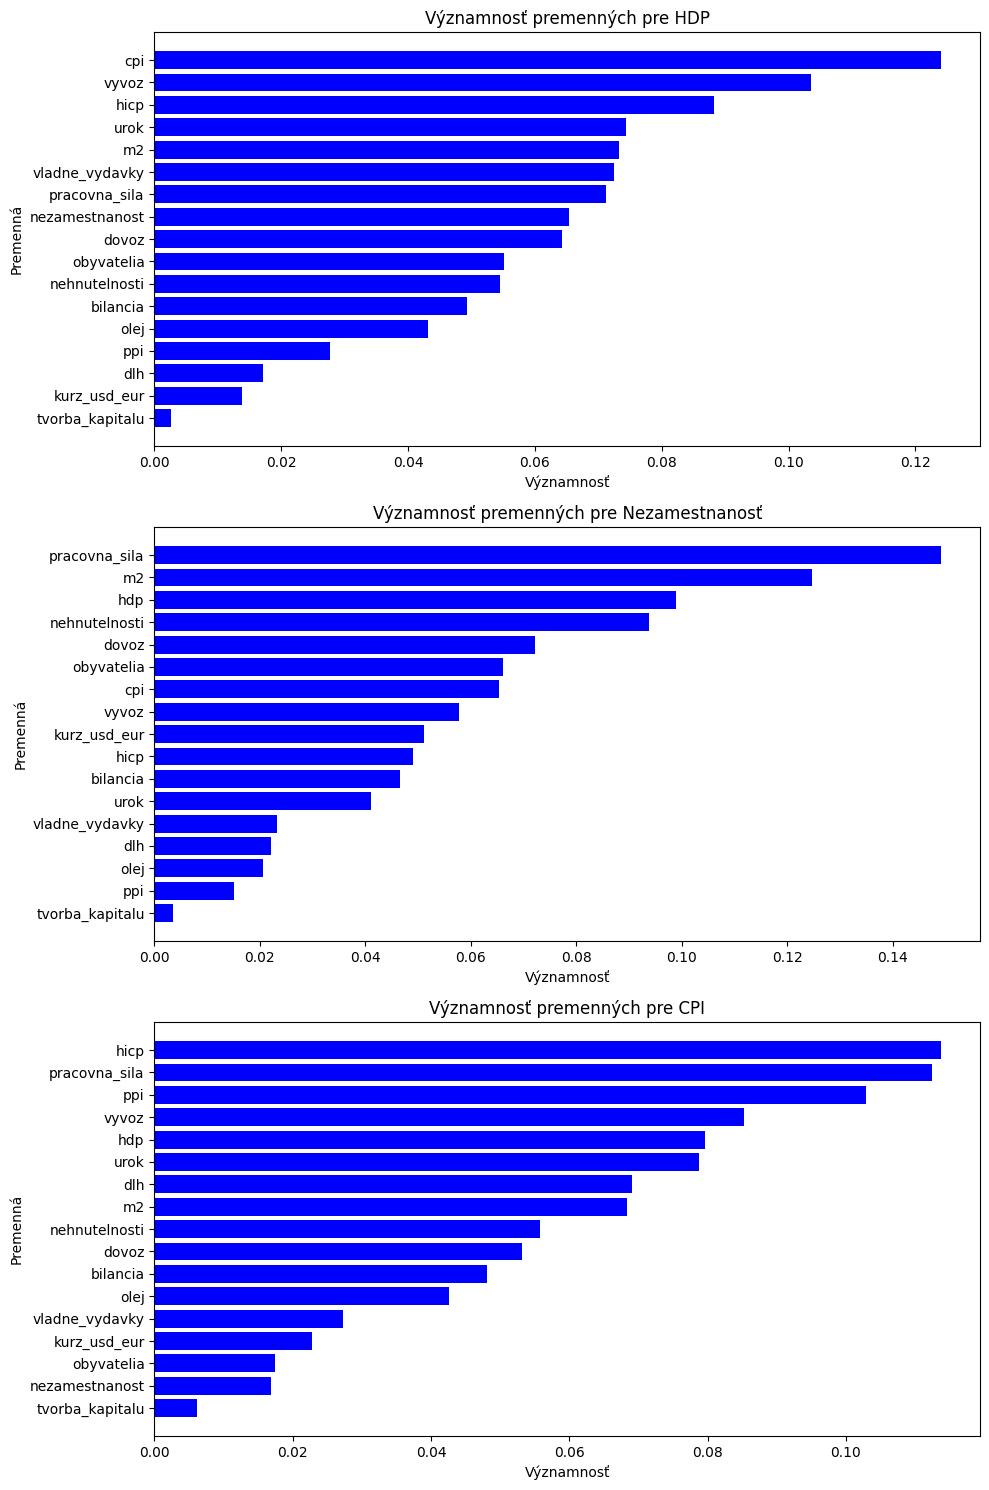

In [14]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib

# Slovník so všetkými modelmi a príslušnými dátami
models = {
    "HDP": {"model": ann_loaded_hdp, "X_test": X_test_hdp, "feature_names": X_hdp.columns},
    "Nezamestnanosť": {"model": ann_loaded_nezamestnanost, "X_test": X_test_nezamestnanost, "feature_names": X_nezamestnanost.columns},
    "CPI": {"model": ann_loaded_cpi, "X_test": X_test_cpi, "feature_names": X_cpi.columns}
}


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))


for idx, (target, data) in enumerate(models.items()):
    model = data["model"]
    feature_names = data["feature_names"]
    X_test = data["X_test"]


    # Inicializácia modelu
    _ = model.predict(np.zeros((1, X_test.shape[1]), dtype=np.float32))  # Inicializácia vstupu

    # Inicializácia SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, X_test[:50])  # Použijeme 50 vzoriek pre vysvetlenie

    # Výpočet SHAP hodnôt
    shap_values = explainer.shap_values(X_test[:200])  # Použijeme 200 vzoriek

    # Spracovanie výstupu SHAP na 1D pole
    if isinstance(shap_values, list):  # Ak model má viac výstupov, spriemerujeme cez všetky výstupy
        shap_values = np.mean(np.abs(shap_values), axis=(0, 1))
    else:
        shap_values = np.mean(np.abs(shap_values), axis=0)

    # Normalizácia tak, aby súčet výzanmností = 1 (ako v stromových modeloch)
    shap_values /= shap_values.sum()

    # Vytvorenie DataFrame pre vizualizáciu
    feature_importance_df = pd.DataFrame({
        "Premenná": feature_names,
        "Významnosť": shap_values.flatten()
    }).sort_values(by="Významnosť", ascending=False)

    # Vykreslenie grafu výzanmnosti premenných na príslušnej subplot osi
    ax = axes[idx]
    ax.barh(feature_importance_df["Premenná"], feature_importance_df["Významnosť"], color="blue")
    ax.set_xlabel("Významnosť")
    ax.set_ylabel("Premenná")
    ax.set_title(f"Významnosť premenných pre {target}")
    ax.invert_yaxis() 


plt.tight_layout()
plt.show()
